In [ ]:
# Data_Skytaxi.csv
# city_dict.csv
# tariff_dict.csv

# Задание 1
# Изучите утренние и вечерние часы пик.

# 1. Постройте график с количеством заказов по суточным часам (на оси Х — часы от 0 до 23).
# 2. На сколько за один час в среднем делается больше заказов в часы пик, чем в обычное время? (По всем городам вместе.)


# 1. Рассмотрите города по отдельности: для каждого города выведите разницу в количестве заказов (среднечасовом) 
#     между часами пик и обычными часами.
# 2. В каком городе наблюдается наибольшее отклонение конверсии Order2Ride в часы пик по сравнению с обычными часами?

In [1]:
import pandas as pd
import scipy.stats as st
import numpy as np
import seaborn as sns
from datetime import datetime
from matplotlib import pyplot as plt
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats
import bootstrapped.compare_functions as bs_compare

In [2]:
data_skytaxi = pd.read_csv('Data_Skytaxi.csv', sep = ';')
city_dict = pd.read_csv('city_dict.csv', sep = ';')
tariff_dict = pd.read_csv('tariff_dict.csv', sep = ';')
data_skytaxi.info()
data_skytaxi.describe()
data_skytaxi = data_skytaxi.merge(city_dict, on='id_city')
data_skytaxi = data_skytaxi.merge(tariff_dict, on='id_tariff')
data_skytaxi['order_time'] = pd.to_datetime(data_skytaxi['order_time'])
data_skytaxi['assign_time'] = pd.to_datetime(data_skytaxi['assign_time'])
data_skytaxi['arrive_time'] = pd.to_datetime(data_skytaxi['arrive_time'])
data_skytaxi['ride_finish_time'] = pd.to_datetime(data_skytaxi['ride_finish_time'])
data_skytaxi['hour'] =  data_skytaxi['order_time'].dt.hour

data_skytaxi

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10020 entries, 0 to 10019
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   order_id          10020 non-null  int64 
 1   id_tariff         10020 non-null  int64 
 2   id_city           10020 non-null  int64 
 3   order_time        10020 non-null  object
 4   assign_time       6743 non-null   object
 5   arrive_time       5345 non-null   object
 6   ride_finish_time  4834 non-null   object
dtypes: int64(3), object(4)
memory usage: 548.1+ KB


,order_id,id_tariff,id_city,order_time,assign_time,arrive_time,ride_finish_time,name_city,name_tariff,hour
0,1146020,111,13,2022-04-08 07:12:00,NaT,NaT,NaT,Казань,Эконом,7
1,1137156,111,13,2022-02-08 15:00:00,2022-02-08 15:02:00,2022-02-08 15:11:00,2022-02-08 15:26:00,Казань,Эконом,15
2,1137323,111,13,2022-04-08 09:07:00,NaT,NaT,NaT,Казань,Эконом,9
3,1145573,111,13,2022-06-08 23:33:00,NaT,NaT,NaT,Казань,Эконом,23
4,1142144,111,13,2022-01-08 18:14:00,NaT,NaT,NaT,Казань,Эконом,18
...,...,...,...,...,...,...,...,...,...,...
10015,1137067,115,14,2022-05-08 16:29:00,2022-05-08 16:38:00,2022-05-08 16:55:00,2022-05-08 17:08:00,Новосибирск,Доставка,16
10016,1142641,115,14,2022-04-08 05:24:00,NaT,NaT,NaT,Новосибирск,Доставка,5
10017,1136917,115,14,2022-03-08 02:59:00,2022-03-08 03:06:00,2022-03-08 03:25:00,2022-03-08 03:35:00,Новосибирск,Доставка,2
10018,1146236,115,14,2022-01-08 07:18:00,2022-01-08 07:22:00,2022-01-08 07:42:00,2022-01-08 07:54:00,Новосибирск,Доставка,7


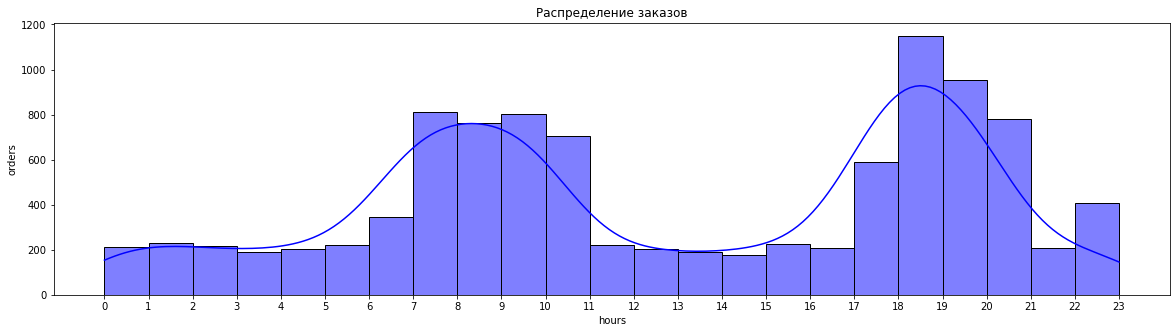

In [3]:
# 1. Постройте график с количеством заказов по суточным часам (на оси Х — часы от 0 до 23).
def show_hist(df, title='Распределение заказов'):
    plt.rcParams["figure.figsize"] = (20, 5)
    sns.histplot(df,
                kde=True,
                color='blue',
                bins=23) # функция построения распределения
    x_ticks = [i for i in range(0,24)]
    plt.xticks(ticks=x_ticks)
    plt.xlabel('hours')
    plt.ylabel('orders')
    plt.title(title)
    plt.show()

show_hist(data_skytaxi['hour'])

In [7]:
# 2. На сколько за один час в среднем делается больше заказов в часы пик, чем в обычное время? (По всем городам вместе.)
def calc_delta_peak_hour(df, city=''):
    orders_by_hours = df['order_id'].groupby(df['hour']).count().reset_index()

    orders_not_peak_hour = orders_by_hours[(orders_by_hours['hour'] <= 6) |
                                           ((orders_by_hours['hour'] >= 11) & (orders_by_hours['hour'] <= 16)) |
                                           ((orders_by_hours['hour'] >= 21))].mean()['order_id']
    orders_peak_hour = orders_by_hours[((orders_by_hours['hour'] >= 7) & (orders_by_hours['hour'] <= 10)) |
                                       ((orders_by_hours['hour'] >= 17) & (orders_by_hours['hour'] <= 20))].mean()['order_id']

    delta_peak_hour = orders_peak_hour - orders_not_peak_hour
    print(f'{city} cредняя разница между кол-вом заказов в часы пик и обычное время: {int(delta_peak_hour)}')
    return(delta_peak_hour)

calc_delta_peak_hour(data_skytaxi)


 cредняя разница между кол-вом заказов в часы пик и обычное время: 602


602.4375

В Казань: cредняя разница между кол-вом заказов в часы пик и обычное время: 56
В Москва: cредняя разница между кол-вом заказов в часы пик и обычное время: 182
В Тюмень: cредняя разница между кол-вом заказов в часы пик и обычное время: 36
В Краснодар: cредняя разница между кол-вом заказов в часы пик и обычное время: 46
В Санкт-Петербург: cредняя разница между кол-вом заказов в часы пик и обычное время: 119
В Екатеринбург: cредняя разница между кол-вом заказов в часы пик и обычное время: 35
В Хабаровск: cредняя разница между кол-вом заказов в часы пик и обычное время: 38
В Красноярск: cредняя разница между кол-вом заказов в часы пик и обычное время: 30
В Новосибирск: cредняя разница между кол-вом заказов в часы пик и обычное время: 54


,city,delta_peak_hour
0,Казань,56.9375
1,Москва,182.8125
2,Тюмень,36.6250
3,Краснодар,46.9375
4,Санкт-Петербург,119.7500
5,Екатеринбург,35.4375
6,Хабаровск,38.8125
7,Красноярск,30.6250
8,Новосибирск,54.5000


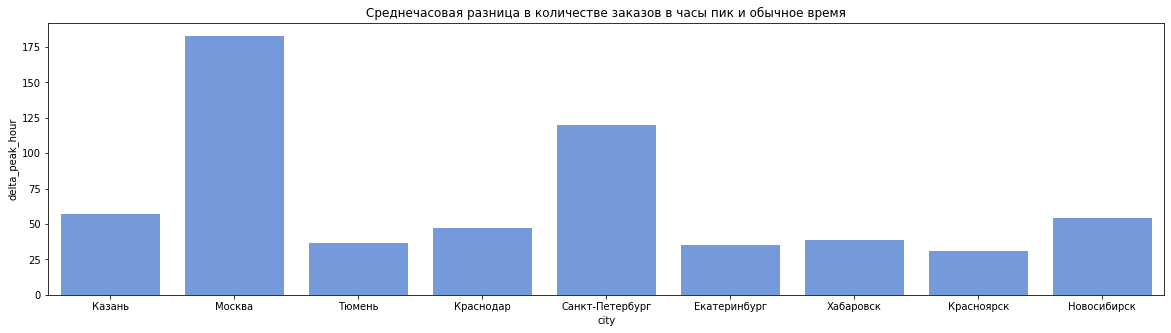

In [47]:
# 1. Рассмотрите города по отдельности: для каждого города выведите разницу в количестве заказов (среднечасовом) 

df_delta_peak_hour = pd.DataFrame(columns=['city', 'delta_peak_hour'])
for city in data_skytaxi['name_city'].unique():
#     show_hist(data_skytaxi['hour'][data_skytaxi['name_city'] == city], f'Распределение заказов в {city}')
    delta_peak_hour = calc_delta_peak_hour(data_skytaxi[data_skytaxi['name_city'] == city], f'В {city}:')
    df_delta_peak_hour.loc[len(df_delta_peak_hour)] = [city, delta_peak_hour]
sns.barplot(x=df_delta_peak_hour['city']
            , y=df_delta_peak_hour['delta_peak_hour']
            , color='cornflowerblue').set(title='Среднечасовая разница в количестве заказов в часы пик и обычное время')
df_delta_peak_hour

In [55]:
# 2. В каком городе наблюдается наибольшее отклонение конверсии Order2Ride в часы пик по сравнению с обычными часами?
# ОТВЕТ: в Москве наблюдается наибольшее отклонение O2R - на 11,6 п.п. O2R в часы пик меньше, чем в обычное время.
def calc_o2r(df, city=''):
    o2r = df[df['ride_finish_time'].notnull()]['order_id'].count()/df['order_id'].count()
    orders = df['order_time'].groupby(df['hour']).count().reset_index()
    rides = df[df['ride_finish_time'].notnull()]['ride_finish_time'].groupby(df['hour']).count().reset_index()
    o2r_by_hours = orders.merge(rides, on='hour')
    o2r_by_hours['o2r'] = round(o2r_by_hours['ride_finish_time']/o2r_by_hours['order_time'], 2)
    o2r_not_peak_hour = o2r_by_hours[(o2r_by_hours['hour'] <= 6) |
                                    ((o2r_by_hours['hour'] >= 11) & (o2r_by_hours['hour'] <= 16)) |
                                    ((o2r_by_hours['hour'] >= 21))].mean()['o2r']
    o2r_peak_hour = o2r_by_hours[((o2r_by_hours['hour'] >= 7) & (o2r_by_hours['hour'] <= 10)) |
                                ((o2r_by_hours['hour'] >= 17) & (o2r_by_hours['hour'] <= 20))].mean()['o2r']
    delta_o2r_peak_hour = round(o2r_peak_hour - o2r_not_peak_hour, 3)
    print(f'---{city}---')
    print(f'Общий O2R = {round(o2r, 2)}')
    print(f'O2R в час пик= {round(o2r_peak_hour, 3)}')
    print(f'O2R в обычные часы= {round(o2r_not_peak_hour, 3)}')
    print(f'Разница O2R в часы пик по сравнению с обычными часами = {delta_o2r_peak_hour}')
    print('')
    df_o2r.loc[len(df_o2r)] = [city, round(o2r, 2), round(o2r_peak_hour, 2), round(o2r_not_peak_hour, 2), round(delta_o2r_peak_hour, 2)]
    return(df_o2r)

df_o2r = pd.DataFrame(columns=['city', 'o2r', 'o2r_peak_hour', 'o2r_not_peak_hour', 'delta_o2r_peak_hour'])
for city in data_skytaxi['name_city'].unique():
    calc_o2r(data_skytaxi[data_skytaxi['name_city'] == city], city)

df_o2r

---Казань---
Общий O2R = 0.56
O2R в час пик= 0.546
O2R в обычные часы= 0.559
Разница O2R в часы пик по сравнению с обычными часами = -0.012

---Москва---
Общий O2R = 0.48
O2R в час пик= 0.444
O2R в обычные часы= 0.56
Разница O2R в часы пик по сравнению с обычными часами = -0.116

---Тюмень---
Общий O2R = 0.27
O2R в час пик= 0.269
O2R в обычные часы= 0.288
Разница O2R в часы пик по сравнению с обычными часами = -0.019

---Краснодар---
Общий O2R = 0.58
O2R в час пик= 0.568
O2R в обычные часы= 0.602
Разница O2R в часы пик по сравнению с обычными часами = -0.034

---Санкт-Петербург---
Общий O2R = 0.5
O2R в час пик= 0.459
O2R в обычные часы= 0.554
Разница O2R в часы пик по сравнению с обычными часами = -0.096

---Екатеринбург---
Общий O2R = 0.57
O2R в час пик= 0.581
O2R в обычные часы= 0.561
Разница O2R в часы пик по сравнению с обычными часами = 0.02

---Хабаровск---
Общий O2R = 0.26
O2R в час пик= 0.281
O2R в обычные часы= 0.224
Разница O2R в часы пик по сравнению с обычными часами = 0.05

,city,o2r,o2r_peak_hour,o2r_not_peak_hour,delta_o2r_peak_hour
0,Казань,0.56,0.55,0.56,-0.01
1,Москва,0.48,0.44,0.56,-0.12
2,Тюмень,0.27,0.27,0.29,-0.02
3,Краснодар,0.58,0.57,0.60,-0.03
4,Санкт-Петербург,0.50,0.46,0.55,-0.10
5,Екатеринбург,0.57,0.58,0.56,0.02
6,Хабаровск,0.26,0.28,0.22,0.06
7,Красноярск,0.39,0.41,0.36,0.05
8,Новосибирск,0.59,0.59,0.61,-0.02


In [ ]:
# Задание 1
# Изучите заказы в Хабаровске и Тюмени. Эти города интересуют менеджеров, так как в них наша компания начала 
# работать относительно недавно.

#  1. На сколько процентных пунктов Order2Ride в среднем в них ниже, чем в других городах?
#  2. За счет какого звена воронки достигается эта разница? Сделайте выводы по Хабаровску и по Тюмени по отдельности.
#  3. Какие рекомендации вы можете дать локальным менеджерам?


In [8]:
#  1. На сколько процентных пунктов Order2Ride в среднем в них ниже, чем в других городах?

Khabarovsk_delta_o2r = calc_o2r(data_skytaxi)[0] - calc_o2r(data_skytaxi[data_skytaxi['name_city'] == 'Хабаровск'], 'Хабаровск')[0]
Tyumen_delta_o2r = calc_o2r(data_skytaxi)[0] - calc_o2r(data_skytaxi[data_skytaxi['name_city'] == 'Тюмень'], 'Тюмень')[0]
print(f'На {round(Khabarovsk_delta_o2r, 3)} п.п. o2r в среднем в Хабаровске ниже, чем в других города')
print(f'На {round(Tyumen_delta_o2r, 3)}  п.п. o2r в среднем в Тюмене ниже, чем в других города')


------
Общий O2R = 0.48
O2R в час пик= 0.464
O2R в обычные часы= 0.518
Разница O2R в часы пик по сравнению с обычными часами = -0.054

---Хабаровск---
Общий O2R = 0.26
O2R в час пик= 0.281
O2R в обычные часы= 0.224
Разница O2R в часы пик по сравнению с обычными часами = 0.057

------
Общий O2R = 0.48
O2R в час пик= 0.464
O2R в обычные часы= 0.518
Разница O2R в часы пик по сравнению с обычными часами = -0.054

---Тюмень---
Общий O2R = 0.27
O2R в час пик= 0.269
O2R в обычные часы= 0.288
Разница O2R в часы пик по сравнению с обычными часами = -0.019

На 0.22 п.п. o2r в среднем в Хабаровске ниже, чем в других города
На 0.215  п.п. o2r в среднем в Тюмене ниже, чем в других города


In [105]:
#  2. За счет какого звена воронки достигается эта разница? Сделайте выводы по Хабаровску и по Тюмени по отдельности.
# ОТВЕТ: В Хабаровске проседает O2A=0,34, 
# в Тюмене тоже сниженный O2A=0,56, но в большей степени просел A2R=0.57 (по сравнению с A2R=0.90)
def calc_funnel(df, definition=''):
    o2a = df[df['assign_time'].notnull()]['order_id'].count()/df['order_id'].count()
    a2a = df[df['arrive_time'].notnull()]['order_id'].count()/df[df['assign_time'].notnull()]['order_id'].count()
    a2r = df[df['ride_finish_time'].notnull()]['order_id'].count()/df[df['arrive_time'].notnull()]['order_id'].count()
    o2r = df[df['ride_finish_time'].notnull()]['order_id'].count()/df['order_id'].count()
    df_funnel.loc[len(df_funnel)] = [definition, round(o2a, 2), round(a2a, 2), round(a2r, 2), round(o2r, 2)]
    return(df_funnel)

df_funnel = pd.DataFrame(columns=['dimension','O2A','A2A','A2R','O2R'])
calc_funnel(data_skytaxi[data_skytaxi['name_city'] == 'Хабаровск'], 'Хабаровск')
calc_funnel(data_skytaxi[data_skytaxi['name_city'] == 'Тюмень'], 'Тюмень')
calc_funnel(data_skytaxi, 'Общий')
df_funnel

,dimension,O2A,A2A,A2R,O2R
0,Хабаровск,0.34,0.81,0.95,0.26
1,Тюмень,0.56,0.84,0.57,0.27
2,Общий,0.67,0.79,0.90,0.48


In [68]:
#  3. Какие рекомендации вы можете дать локальным менеджерам?
# В Хабаровске проседает O2A=0,34, в Тюмене тоже сниженный O2A=0,56, но в большей степени просел A2R=0.57 
# (по сравнению с A2R=0.90)
def calc_delta_time(r1, r2, city='', delta_time = ''):
    df = pd.DataFrame()
    df['delta'] = r2-r1
    df.drop(df[df.delta > np.timedelta64(4, 'h')].index, inplace=True)
    mean_delta_time = df['delta'].mean()
    print(f'---{city}---')
    print(f'---{delta_time}---')
    print(mean_delta_time)
    print('')
    df_delta.loc[len(df_delta)] = [city, mean_delta_time]
    return df_delta

df_delta = pd.DataFrame(columns=['city', 'time O2A'])
for city in data_skytaxi['name_city'].unique():
    calc_delta_time(data_skytaxi[data_skytaxi['name_city'] == city]['order_time']
                    , data_skytaxi[data_skytaxi['name_city'] == city]['assign_time']
                    , city
                    , 'O2A')
df_delta

df_delta = pd.DataFrame(columns=['city', 'time A2R'])
for city in data_skytaxi['name_city'].unique():
    calc_delta_time(data_skytaxi[data_skytaxi['name_city'] == city]['arrive_time']
                    , data_skytaxi[data_skytaxi['name_city'] == city]['ride_finish_time']
                    , city
                    , 'A2R')
df_delta

# РЕКОМЕНДАЦИИ: время назначения водителя (O2A) в Хабаровске и Тюмене не отличается от времени назначения в остальных
# городах. Аналогичная ситуация и с временем поездки (A2R) в Тюмене. Необходимо смотреть глубже, кто инициатор отказов,
# из-за которых просели эти этапы воронки


---Казань---
---O2A---
0 days 00:04:13.032069970

---Москва---
---O2A---
0 days 00:03:53.881578947

---Тюмень---
---O2A---
0 days 00:04:15.942857142

---Краснодар---
---O2A---
0 days 00:04:21.978021978

---Санкт-Петербург---
---O2A---
0 days 00:04:00.220588235

---Екатеринбург---
---O2A---
0 days 00:04:08.100686498

---Хабаровск---
---O2A---
0 days 00:04:31.848341232

---Красноярск---
---O2A---
0 days 00:04:05.904255319

---Новосибирск---
---O2A---
0 days 00:04:22.654028436

---Казань---
---A2R---
0 days 00:13:59.287128712

---Москва---
---A2R---
0 days 00:22:53.346693386

---Тюмень---
---A2R---
0 days 00:10:37.278106508

---Краснодар---
---A2R---
0 days 00:13:55.654205607

---Санкт-Петербург---
---A2R---
0 days 00:17:23.906705539

---Екатеринбург---
---A2R---
0 days 00:14:07.747747747

---Хабаровск---
---A2R---
0 days 00:10:27.407407407

---Красноярск---
---A2R---
0 days 00:10:46.153846153

---Новосибирск---
---A2R---
0 days 00:10:39.559118236



,city,time A2R
0,Казань,0 days 00:13:59.287128712
1,Москва,0 days 00:22:53.346693386
2,Тюмень,0 days 00:10:37.278106508
3,Краснодар,0 days 00:13:55.654205607
4,Санкт-Петербург,0 days 00:17:23.906705539
5,Екатеринбург,0 days 00:14:07.747747747
6,Хабаровск,0 days 00:10:27.407407407
7,Красноярск,0 days 00:10:46.153846153
8,Новосибирск,0 days 00:10:39.559118236


In [103]:
# Задание 3
# К вам обратились коллеги из отдела антифрода (отдела, предотвращающего мошенничество). У них есть подозрение, 
# что некоторые водители мимикрируют координаты, то есть на самом деле не приезжают в точку А своего заказа, 
# но в приложение посылают сигнал, что они в эту точку А приехали. Таким образом они вынуждают клиента отменить 
# заказ после «прибытия ими в точку А».

# Постарайтесь локализовать данную проблему и выделить города, в которых такое происходит чаще всего.
# Обратите внимание на последнее звено воронки.
def detect_antifrod(df):
    df_for_antifrod = df[df['ride_finish_time'].isnull() & df['arrive_time'].notnull()]
    df_for_antifrod['delta'] = df['arrive_time'] - df['assign_time']
    df_for_antifrod.sort_values(by='delta', inplace=True)
    df_for_antifrod = df_for_antifrod[df_for_antifrod.delta <= np.timedelta64(2, 'm')]
    return df_for_antifrod['order_id'].groupby(df_for_antifrod['name_city']).count().sort_values(ascending=False)

detect_antifrod(data_skytaxi)
# Короткий временной промежуток между назначением водителя (assign_time) и его прибытием (arrive_time) может быть следствием мимикрии
# координат. Будем считать, что если дельта между прибытием и назначением меньше или равна 2 минутам, тогда это причина
# подозревать водителя в мошенничестве. Данные заказы стоит детально проанализировать (проверить изменения геолокации)
# Чаще всего данные кейсы встречаются в Москве (10), СПБ (4) и Тюмене (4)

C:\Users\User\AppData\Local\Temp\ipykernel_9392\3254222819.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_for_antifrod['delta'] = df['arrive_time'] - df['assign_time']
C:\Users\User\AppData\Local\Temp\ipykernel_9392\3254222819.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_for_antifrod.sort_values(by='delta', inplace=True)


name_city
Москва             10
Санкт-Петербург     4
Тюмень              4
Новосибирск         2
Казань              1
Краснодар           1
Name: order_id, dtype: int64

In [107]:
def bootstrap_ab_func(r1, r2):
    r1 = r1.values
    r2 = r2.values
    boot_results = bs.bootstrap_ab(ctrl = r1, test = r2
                                  , stat_func = bs_stats.mean
                                  , compare_func = bs_compare.difference
                                  , return_distribution=True)
    borders = np.percentile(boot_results, [2.5, 97.5])
    dist = sns.distplot(boot_results) # функция построения распределения
    plt.title('Bootstrap-распределение')
    plt.rcParams["figure.figsize"] = (12, 6)
    plt.vlines(0, # отрисуем линию на уровне ноля
               ymin = 0, 
               ymax = dist.get_ylim()[1], 
               linestyles= '--', 
               colors = 'red')
    plt.vlines(borders, # отрисуем перцентили
               ymin = 0, 
               ymax = dist.get_ylim()[1], 
               linestyles= '--', 
               colors = 'grey', 
               label = '95%-доверительный интервал')
    plt.legend()
    plt.show()
    if borders[0] > 0:
        print(f'По результатам бутстрапа видно, что отметка 0 не входит в доверительный интервал, и т.к. '\
              'распределение находится правее 0 - тестовая группа показала лучший результат, чем контрольная.')
    elif (borders[0] < 0) & (borders[1] > 0):
        print(f'По результатам бутстрапа видно, что отметка 0 входит в доверительный интервал, -'\
              ' тестовая группа не отличается от контрольной.')
    else:
        print(f'По результатам бутстрапа видно, что отметка 0 не входит в доверительный интервал, и т.к. '\
              'распределение находится левее 0 - тестовая группа показала худший результат, чем контрольная.')
        
def test_calc(r1, r2, alpha=0.05):
    s, p = st.ttest_ind(r1, r2)
    print("Среднее значение 1 ряда", r1.mean())
    print("Среднее значение 2 ряда", r2.mean())
    print("Разница средних = ", r1.mean()-r2.mean())
    if p > alpha:
        print(f'Нулевая гипотеза о равенстве средних принимается, т.к. p_value = {p}, что больше чем {alpha}. '\
              f'Значение стат критерия {s}')
    else:
        print(f'Нулевая гипотеза о равенстве средних отвергается, т.к. p_value = {p}, что меньше чем {alpha}. '\
              f'Значение стат критерия {s}')
    return s, p

In [109]:
# Задание 4
# Тариф «Доставка» был запущен недавно по всей России. Изучите конверсии в рамках данного тарифа по 
# городам, локализуйте просадку конверсии Order2Ride в рамках данного тарифа и дайте рекомендации отделу 
# операционистов, которые занимаются этим тарифом.
# 1. Исключите из рассмотрения города, в которых недостаточно наблюдений для оценки.
# 2. Посмотрите O2R по городам и выделите города с наименьшим показателем.
data_skytaxi['flag_o2r'] = data_skytaxi['ride_finish_time'].notnull().astype('int')
df_funnel = pd.DataFrame(columns=['dimension','O2A','A2A','A2R','O2R'])
calc_funnel(data_skytaxi[data_skytaxi['name_tariff'] == 'Доставка'], 'Общий Доставка')
for city in data_skytaxi['name_city'].unique():
    calc_funnel(data_skytaxi[(data_skytaxi['name_tariff'] == 'Доставка') 
                & (data_skytaxi['name_city'] == city)]
                , f'{city} Доставка')
print(df_funnel)
print(data_skytaxi[data_skytaxi['name_tariff'] == 'Доставка']['ride_finish_time'].groupby(data_skytaxi['name_city']).count().sort_values(ascending=False))

for city in data_skytaxi['name_city'].unique():
    if (city != 'Хабаровск') & (city != 'Тюмень') & (city != 'Краснодар'):
        print(f'----Сравнение Хабаровск с {city}----')
        test_calc(data_skytaxi['flag_o2r'][(data_skytaxi['name_city'] == 'Хабаровск') 
                                           & (data_skytaxi['name_tariff'] == 'Доставка')], 
                  data_skytaxi['flag_o2r'][(data_skytaxi['name_city'] == city) 
                                           & (data_skytaxi['name_tariff'] == 'Доставка')])
        print(f'----Сравнение Тюмень с {city}----')
        test_calc(data_skytaxi['flag_o2r'][(data_skytaxi['name_city'] == 'Тюмень') 
                                           & (data_skytaxi['name_tariff'] == 'Доставка')], 
                  data_skytaxi['flag_o2r'][(data_skytaxi['name_city'] == city) 
                                           & (data_skytaxi['name_tariff'] == 'Доставка')])
        print()
df_funnel

# Тюмень и Хабаровск показывают наименьшие показатели O2R в тарифе Доставка. В расчетах не учитываем Краснодар,
# т.к. в нет данных для анализа


                  dimension   O2A   A2A   A2R   O2R
0            Общий Доставка  0.66  0.78  0.93  0.48
1           Казань Доставка  0.76  0.81  0.97  0.60
2           Москва Доставка  0.70  0.76  0.95  0.51
3           Тюмень Доставка  0.25  0.73  0.88  0.16
4        Краснодар Доставка  0.00   NaN   NaN  0.00
5  Санкт-Петербург Доставка  0.73  0.74  0.95  0.51
6     Екатеринбург Доставка  0.79  0.84  0.90  0.60
7        Хабаровск Доставка  0.34  0.75  0.92  0.23
8       Красноярск Доставка  0.82  0.81  0.72  0.47
9      Новосибирск Доставка  0.66  0.91  0.97  0.58
name_city
Москва             112
Санкт-Петербург     70
Новосибирск         38
Казань              33
Екатеринбург        28
Красноярск          18
Хабаровск           11
Тюмень               7
Краснодар            0
Name: ride_finish_time, dtype: int64
----Сравнение Хабаровск с Казань----
Среднее значение 1 ряда 0.23404255319148937
Среднее значение 2 ряда 0.6
Разница средних =  -0.3659574468085106
Нулевая гипотеза о равенст

C:\Users\User\AppData\Local\Temp\ipykernel_9392\1140169686.py:6: RuntimeWarning: invalid value encountered in longlong_scalars
  a2a = df[df['arrive_time'].notnull()]['order_id'].count()/df[df['assign_time'].notnull()]['order_id'].count()
C:\Users\User\AppData\Local\Temp\ipykernel_9392\1140169686.py:7: RuntimeWarning: invalid value encountered in longlong_scalars
  a2r = df[df['ride_finish_time'].notnull()]['order_id'].count()/df[df['arrive_time'].notnull()]['order_id'].count()


,dimension,O2A,A2A,A2R,O2R
0,Общий Доставка,0.66,0.78,0.93,0.48
1,Казань Доставка,0.76,0.81,0.97,0.60
2,Москва Доставка,0.70,0.76,0.95,0.51
3,Тюмень Доставка,0.25,0.73,0.88,0.16
4,Краснодар Доставка,0.00,NaN,NaN,0.00
5,Санкт-Петербург Доставка,0.73,0.74,0.95,0.51
6,Екатеринбург Доставка,0.79,0.84,0.90,0.60
7,Хабаровск Доставка,0.34,0.75,0.92,0.23
8,Красноярск Доставка,0.82,0.81,0.72,0.47
9,Новосибирск Доставка,0.66,0.91,0.97,0.58


----Сравнение Доставки с Эконом----
Среднее значение 1 ряда 0.48396946564885496
Среднее значение 2 ряда 0.4897626803164262
Разница средних =  -0.005793214667571267
Нулевая гипотеза о равенстве средних принимается, т.к. p_value = 0.7823735177378696, что больше чем 0.05. Значение стат критерия -0.27624227703747206


C:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


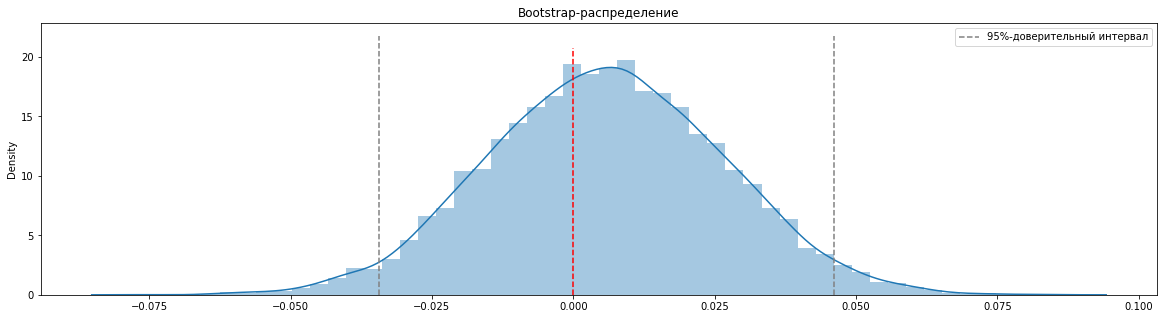

По результатам бутстрапа видно, что отметка 0 входит в доверительный интервал, - тестовая группа не отличается от контрольной.

----Сравнение Доставки с Комфорт----
Среднее значение 1 ряда 0.48396946564885496
Среднее значение 2 ряда 0.4826577517760134
Разница средних =  0.001311713872841569
Нулевая гипотеза о равенстве средних принимается, т.к. p_value = 0.9525526035142586, что больше чем 0.05. Значение стат критерия 0.05950648551817487


C:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


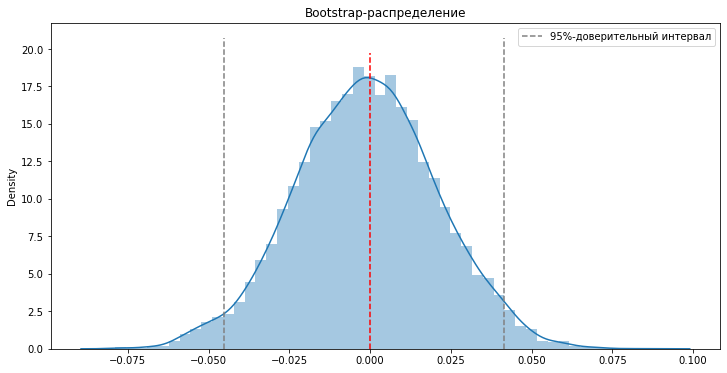

По результатам бутстрапа видно, что отметка 0 входит в доверительный интервал, - тестовая группа не отличается от контрольной.

----Сравнение Доставки с Бизнес----
Среднее значение 1 ряда 0.48396946564885496
Среднее значение 2 ряда 0.4668109668109668
Разница средних =  0.01715849883788817
Нулевая гипотеза о равенстве средних принимается, т.к. p_value = 0.46877918435996335, что больше чем 0.05. Значение стат критерия 0.7246022994886587


C:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


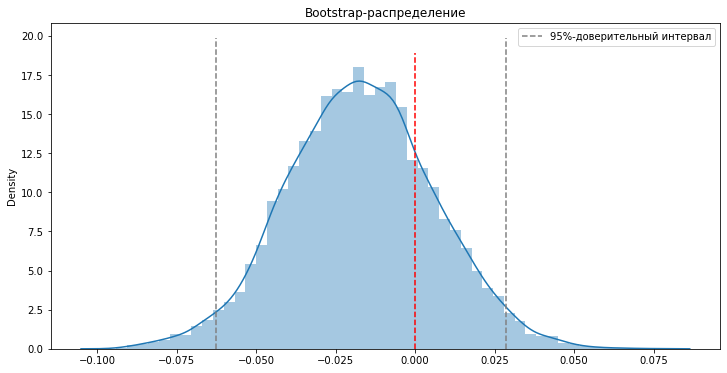

По результатам бутстрапа видно, что отметка 0 входит в доверительный интервал, - тестовая группа не отличается от контрольной.

----Сравнение Доставки с Комфорт+----
Среднее значение 1 ряда 0.48396946564885496
Среднее значение 2 ряда 0.47360248447204967
Разница средних =  0.01036698117680529
Нулевая гипотеза о равенстве средних принимается, т.к. p_value = 0.6655767544647266, что больше чем 0.05. Значение стат критерия 0.4322926422688504


C:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


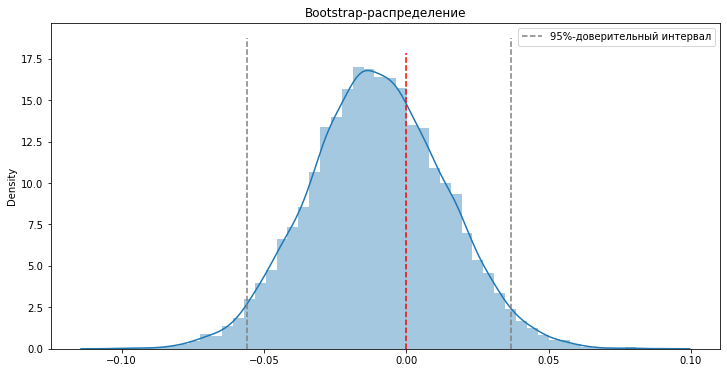

По результатам бутстрапа видно, что отметка 0 входит в доверительный интервал, - тестовая группа не отличается от контрольной.



In [15]:
# 3. Посмотрите конверсии-звенья O2R и визуализируйте их с доверительными интервалами для конверсий.
# 4. Визуализируйте O2R-доставки по сравнению с O2R других тарифов.

for tariff in data_skytaxi['name_tariff'].unique():
    if tariff != 'Доставка':
        print(f'----Сравнение Доставки с {tariff}----')
        test_calc(data_skytaxi['flag_o2r'][(data_skytaxi['name_tariff'] == 'Доставка')], 
                  data_skytaxi['flag_o2r'][(data_skytaxi['name_tariff'] == tariff)])
        bootstrap_ab_func(data_skytaxi['flag_o2r'][(data_skytaxi['name_tariff'] == 'Доставка')], 
                          data_skytaxi['flag_o2r'][(data_skytaxi['name_tariff'] == tariff)])
        print()
# Отличий тарифа Доставка от остальных тарифов нет, значения конверсии равны.

In [ ]:
# Дополнительное задание*
# Вы обратились к дата-инженерам, и они согласились создать таблицы в «Хранилище», соответствующие .csv-файлам 
# из этого кейса. Подготовьте SQL-скрипты, которые будут производить расчеты данных заданий Ad hoc на уровне «Хранилища».
